In this assignment, I will be implementing the interleaver as described in option 2.3

In [1]:
# Packages you should already have installed, to be imported:

import numpy as np

π = np.pi
import matplotlib.pyplot as plt
import sounddevice as sd
sd.default.channels = 1

rng = np.random.default_rng(76)

In [2]:
# Write your convolutional encoder in this cell.

def conv_encode(message):
    """Encodes the `message` using the convolutional code discussed in lecture.
    `message` should be a 1-D `np.ndarray` of integers, all 1 or 0.
    Returns a 1-D `np.ndarray` of integers, all 1 or 0.
    """
    result = np.array([], dtype='uint8')
    
    # add padding
    message = np.append(message, np.uint8(0))
    message = np.append(message, np.uint8(0))
    
    buf = np.array([0, 0])
    
    for bit in message:
        buf = np.insert(buf, 0, bit)
        result = np.append(result, (buf[0] ^ buf[1] ^ buf[2]))
        result = np.append(result, (buf[0] ^ buf[2]))
        buf = buf[0:2]
        
    return result

In [3]:
def viterbi_decode(encoded):
    """Decodes the `message` using the Viterbi decoder discussed in lecture.
    `encoded` should be an iterable of integers, all 1 or 0.
    Returns an `np.ndarray` with `dtype=uint8`."""
    
    viterbi_cell = [
    # indices are next state (states: 0 = 00, 1 = 01, 2 = 10, 3 = 11)
    # tuples are: (prev state, message bit, encoded word)
    ((0, 0, np.array([0, 0], dtype='uint8')),
     (1, 0, np.array([1, 1], dtype='uint8'))),
    ((2, 0, np.array([1, 0], dtype='uint8')),
     (3, 0, np.array([0, 1], dtype='uint8'))),
    ((0, 1, np.array([1, 1], dtype='uint8')),
     (1, 1, np.array([0, 0], dtype='uint8'))),
    ((2, 1, np.array([0, 1], dtype='uint8')),
     (3, 1, np.array([1, 0], dtype='uint8'))),
    ]
    
    k = len(encoded) // 2
    decoded = np.zeros(k, dtype='uint8')
    
    running_totals = [0, np.inf, np.inf, np.inf]  # respectively for 00, 01, 10, 11
    message_candidates = [[] for i in range(4)]

    for i in range(k):
        word = encoded[2*i:2*i+2]
        
        next_totals = [None, None, None, None]
        next_candidates = [None, None, None, None]

        for next_state, (path1, path2) in enumerate(viterbi_cell):
            # got lazy with a third nested loop here because there are always exactly two paths
            prev1, bit1, true_word1 = path1
            distance1 = np.sum(word != true_word1)
            total1 = running_totals[prev1] + distance1

            prev2, bit2, true_word2 = path2
            distance2 = np.sum(word != true_word2)
            total2 = running_totals[prev2] + distance2
            
            # If total1 == total2, the choice is arbitrary; the randomness here is to test that
            # our test cases don't have multiple correct decodings.
            if total1 < total2 or (total1 == total2 and np.random.rand() < 0.5):
                next_candidates[next_state] = message_candidates[prev1] + [bit1]
                next_totals[next_state] = total1
            else:
                next_candidates[next_state] = message_candidates[prev2] + [bit2]
                next_totals[next_state] = total2

        running_totals = next_totals
        message_candidates = next_candidates

    return np.array(message_candidates[0][:-2], dtype='uint8')

Below, I define my functions, which pseudo permute and reverse the pseudo permutation. This is essentially how a deck of cards is shuffled.

In [4]:
def pseudoPermute(encoded):
    length = encoded.size
    result = np.empty(length)
    for i in range(length):
        if i % 2 == 0:
            result[i] = encoded[i // 2]
        else:
            result[i] = encoded[length - (i // 2) - 1]
            
    return result

In [5]:
def invertedPseudoPermute(received):
    length = received.size
    result = np.empty(length)
    for i in range(length):
        if i % 2 == 0:
            result[i // 2] = received[i]
        else:
            result[length - (i // 2) - 1] = received[i]
            
    return result

Now I test it on a channel with random bitflips.

In [80]:
# Task 2.1. This code runs simulations on your encoder-decoder implementation.
# The following cell will produce a plot of BER before decoding vs. BER after decoding.

# you can increase these, just be aware it'll take longer to run
message_length = 1000
num_messages = 100
num_bers_before = 21

total_num_trials = num_messages * num_bers_before
bers_before_decoding = np.linspace(0, 0.1, num_bers_before)
bers_after_decoding = np.zeros(num_bers_before)

for i, p in enumerate(bers_before_decoding):
    num_bit_errors = 0  # for all messages at this BER before decoding

    for j in range(num_messages):
        print(f"Channel BER {p}, message {j}, {((i*num_messages+j)/total_num_trials):.1%} complete...", end='\r')

        message = rng.integers(2, size=message_length, dtype='uint8')
        encoded = conv_encode(message)
        
        encoded = pseudoPermute(encoded)
        encoded = np.array(encoded, dtype='uint8')

        # flip bits randomly with probability p
        errors = rng.choice(2, size=encoded.size, p=[1-p, p])
        received = encoded ^ errors

        received = invertedPseudoPermute(received)
        
        decoded = viterbi_decode(received)
        num_bit_errors += sum(decoded != message)

    bers_after_decoding[i] = num_bit_errors / (message_length * num_messages)

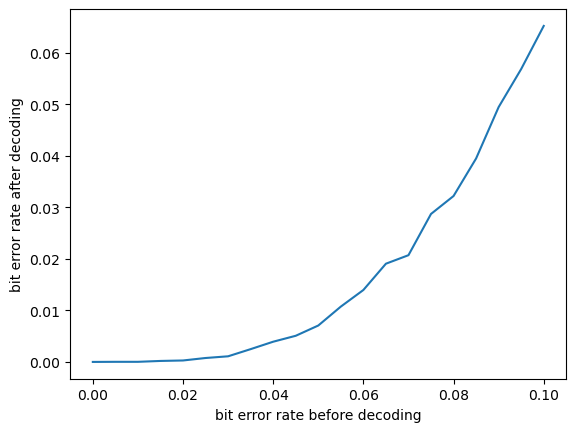

In [81]:
plt.plot(bers_before_decoding, bers_after_decoding)
plt.xlabel("bit error rate before decoding")
plt.ylabel("bit error rate after decoding")
plt.show()

Now I test it on a channel with _burst_ bitflips.

In [88]:
# Task 2.1. This code runs simulations on your encoder-decoder implementation.
# The following cell will produce a plot of BER before decoding vs. BER after decoding.


# you can increase these, just be aware it'll take longer to run
message_length = 1000
num_messages = 100
num_bers_before = 21

total_num_trials = num_messages * num_bers_before
bers_before_decoding = np.linspace(0, 0.1, num_bers_before)
bers_after_decoding = np.zeros(num_bers_before)


for i, p in enumerate(bers_before_decoding):
    num_bit_errors = 0  # for all messages at this BER before decoding

    for j in range(num_messages):
        print(f"Channel BER {p}, message {j}, {((i*num_messages+j)/total_num_trials):.1%} complete...", end='\r')

        message = rng.integers(2, size=message_length, dtype='uint8')
        encoded = conv_encode(message)
        
        encoded = pseudoPermute(encoded)
        encoded = np.array(encoded, dtype='uint8')

        # flip bits in bursts with probability p
        errors = np.zeros(encoded.size)
        if p == 0:
            l = 1000
        else:
            l = int(1//p)
            
        for k in range(0, errors.size, l//2):
            errors[k:k+2] = 1
            
        errors = np.array(errors, dtype='uint8')
        received = encoded ^ errors

        received = invertedPseudoPermute(received)
        
        decoded = viterbi_decode(received)
        num_bit_errors += sum(decoded != message)

    bers_after_decoding[i] = num_bit_errors / (message_length * num_messages)

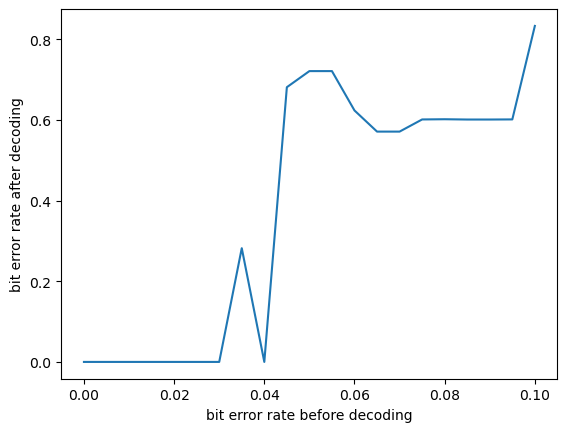

In [89]:
plt.plot(bers_before_decoding, bers_after_decoding)
plt.xlabel("bit error rate before decoding")
plt.ylabel("bit error rate after decoding")
plt.show()

Explanation: the difference between the interleaved bit error rates in the random case and in the burst error case was drastic. In the random bit flip scenario, there was a steady increasing trend to the bit error rate after decoding, with the after decoding bit error rate going up above 0.06 toward a before decoding bit error rate of 0.10. Basically, the interleaver seems to have little to no effect. However, in the permuted scenario with bursts, we see that there is no bit error at all until around 0.03 bit error rate before decoding. It seems that there is also of course some randomness to this process, as the y-value once again drops close to 0 at 0.04. Afterward, the bit error rate after decoding seems to shoot up, so past 0.04 on the burst testing we seem to lose any advantage for the interleaver in this experimental scenario. Overall, this took me many hours to implement, as I first had to think of an algorithm to use for the permutation that I could easily reverse, test it thoroughly, and then integrate it into the simulation code. I also had a lot of trouble figuring out how to implement the burst bit errors, but I settled on using a stepwise range such that the overall expected value of bits flipped is the same, but they are clustered together.